# Assignment 3

Yufei Liu 260561054

In [20]:
from pathlib import Path
import string
import collections
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import warnings; warnings.simplefilter('ignore')

TOP = 10000

## Question 1

Pre-processing data

In [3]:
def preprocessing(dataset):
    translator=str.maketrans(string.punctuation, ' '*len(string.punctuation))
    filepath = Path(dataset)
    text = filepath.read_text()
    text = text.translate(translator).lower()
    return text

Generate vocabulary datasets

In [4]:
def genVocabFile(source, target):
    dataset = preprocessing(source)
    freqwords = collections.Counter()
    for reviews in dataset.splitlines():
        words = reviews.split()[:-1]
        freqwords.update(words)
    freqwords = freqwords.most_common(TOP)
    with open(target, "w", newline='') as textfile:
        writer = csv.writer(textfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for i in range(len(freqwords)):
            writer.writerow([freqwords[i][0], i + 1, freqwords[i][1]])

def genVocab(source):
    dataset = preprocessing(source)
    freqwords = collections.Counter()
    for reviews in dataset.splitlines():
        words = reviews.split()[:-1]
        freqwords.update(words)
    freqwords = freqwords.most_common(TOP)
    vocab = {}
    for i in range(len(freqwords)):
        vocab[freqwords[i][0]] = (i + 1, freqwords[i][1])
    return vocab

Generate review ID datasets

In [5]:
def buildIDFile(source, vocab, target):
    dataset = preprocessing(source)
    reviewByID = []
    count = 0
    for reviews in dataset.splitlines():
        if (len(reviews) == 0):
            continue
        words = reviews.split()
        if not (words[-1].isdigit()):
            continue
        score = int(words[len(words) - 1])
        row = []
        for i in range(len(words) - 1):
            id = vocab.get(words[i], -1)
            if (id != -1):
                row.append(id[0])
        if (len(row) > 0):
            row.append(score)
            reviewByID.append(row)
    with open(target, "w", newline='') as textfile:
        writer = csv.writer(textfile, delimiter=' ')
        for i in range(len(reviewByID)):
            row = []
            score = reviewByID[i][-1]
            for j in range(len(reviewByID[i]) - 1):
                row.append(reviewByID[i][j])
            row.append('\t' + str(score))
            writer.writerow(row)

In [6]:
# yelpVocab = genVocab("hwk3_datasets/yelp-train.txt")
# imdbVocab = genVocab("hwk3_datasets/IMDB-train.txt")

# genVocabFile("hwk3_datasets/yelp-train.txt", "output_datasets/yelp-vocab.txt")
# buildIDFile("hwk3_datasets/yelp-train.txt", yelpVocab, "output_datasets/yelp-train.txt")
# buildIDFile("hwk3_datasets/yelp-test.txt", yelpVocab, "output_datasets/yelp-test.txt")
# buildIDFile("hwk3_datasets/yelp-valid.txt", yelpVocab, "output_datasets/yelp-valid.txt")
#
# genVocabFile("hwk3_datasets/IMDB-train.txt", "output_datasets/IMDB-vocab.txt")
# buildIDFile("hwk3_datasets/IMDB-train.txt", imdbVocab, "output_datasets/IMDB-train.txt")
# buildIDFile("hwk3_datasets/IMDB-test.txt", imdbVocab, "output_datasets/IMDB-test.txt")
# buildIDFile("hwk3_datasets/IMDB-valid.txt", imdbVocab, "output_datasets/IMDB-valid.txt")

Read reviews and ratings from the generated datasets

In [7]:
def getReviews(datapath):
    review = []
    scores = []
    filepath = Path(datapath)
    text = filepath.read_text()
    for comments in text.splitlines():
        row = []
        IDs = comments.split()[:-1]
        score = comments.split()[-1]
        for i in range(len(IDs)):
            row.append(int(IDs[i]))
        review.append(row)
        scores.append(score)

    return (review, scores)

Build binary bag of words, which creates a 10000 dimension vector for each review in a file

In [8]:
def buildBinaryBOW(reviewsID):
    fVector = []
    for i in range(len(reviewsID)):
        row = [0] * TOP
        uniqueSet = set()
        for j in range(len(reviewsID[i])):
            pos = reviewsID[i][j]
            if pos in uniqueSet:
                continue
            row[pos] = 1
            uniqueSet.add(pos)
        fVector.append(row)
    return fVector

Build frequency bag of words, the value in a feature vector would be the occurance frequency of that word. The values of a feature vectore sum to 1

In [9]:
def buildFreqBOW(reviewsID):
    fVector = []
    for i in range(len(reviewsID)):
        uniqueSet = set()
        row = [0] * TOP
        for j in range(len(reviewsID[i])):
            pos = reviewsID[i][j]
            if pos in uniqueSet:
                continue
            count = reviewsID[i].count(pos)
            row[pos] = count/len(reviewsID[i])
            uniqueSet.add(pos)
        fVector.append(row)
    return fVector

# Question 2

Two baseline classifiers by using scikit-learn DummyClassifier

In [40]:
def randomClf(X_train, y_train, X_test, y_test):
    clf_uniform = DummyClassifier(strategy='uniform')
    clf_uniform.fit(X_train, y_train)
    predict_uniform = []
    for i in range(len(X_test)):
        res_uniform = clf_uniform.predict([X_test[i]])
        predict_uniform.append(res_uniform)
    print('Uniform Random F1 Measure = ' + str(metrics.f1_score(y_test, predict_uniform, average='micro')))

def majorityClf(X_train, y_train, X_test, y_test):
    clf_mostFreq = DummyClassifier(strategy='most_frequent')
    clf_mostFreq.fit(X_train, y_train)
    predict_mostFreq = []
    for i in range(len(X_test)):
        res_mostFreq = clf_mostFreq.predict([X_test[i]])
        predict_mostFreq.append(res_mostFreq)
    print('Majority Class F1 Measure = ' + str(metrics.f1_score(y_test, predict_mostFreq, average='micro')))

Prepare for trainning and testing data

In [25]:
trainReviews = getReviews("output_datasets/yelp-train.txt")
trainX = buildBinaryBOW(trainReviews[0])
trainY = trainReviews[1]

validReviews = getReviews("output_datasets/yelp-valid.txt")
validX = buildBinaryBOW(validReviews[0])
validY = validReviews[1]

testReviews = getReviews("output_datasets/yelp-test.txt")
testX = buildBinaryBOW(testReviews[0])
testY = testReviews[1]

In [11]:
randomClf(trainX, trainY, testX, testY)
majorityClf(trainX, trainY, testX, testY)

Uniform Random F1 Measure = 0.2095
Majority Class F1 Measure = 0.351


Ploting function to visualize the training process, to be used later

In [11]:
def plotTrainningProcess(dataset):
    a = np.array(dataset,dtype='float')
    a = np.transpose(a)
    plt.plot(a[1], a[0], 'ro')
    plt.title('Finding Hyper Parameter')
    plt.xlabel('Hyper Parameter')
    plt.ylabel('F1 Measure')
    plt.show()

### Bernoulli Naive Bayes

In [30]:
def BernoulliNativeBayes(X_train, y_train, X_test, y_test, a):
    clf = BernoulliNB(alpha=a)
    clf.fit(X_train, y_train)
    predict = []
    for i in range(len(X_test)):
        res = clf.predict([X_test[i]])
        predict.append(res)
    f1 = metrics.f1_score(y_test, predict, average='micro')
    return f1

Function for finding the best smoothing parameter alpha

In [34]:
def findAlpha_BNB(X_train, y_train, X_test, y_test):
    a = 1.0
    best_alpha = 1.0
    best_f1 = 0
    hyperP = []
    for i in range(25):
        f1 = BernoulliNativeBayes(X_train, y_train, X_test, y_test, a)
        hyperP.append([f1, a])
        if (f1 > best_f1):
            best_f1 = f1
            best_alpha = a
        a *= 0.8
    hyperP.sort()
    plotTrainningProcess(hyperP)
    print("The best smoothing parameter alpha = {} \n F1 measure  = {}".format(best_alpha, best_f1))

Finding the best alpha

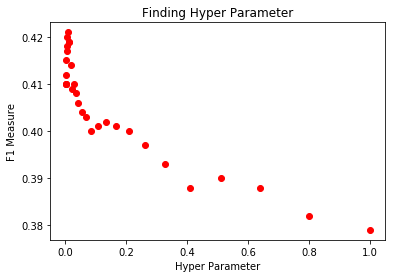

The best smoothing parameter alpha = 0.009223372036854787 
 F1 measure  = 0.421


In [15]:
findAlpha_BNB(trainX, trainY, validX, validY)

Apply the best alpha and predit the test dataset with alpha = 0.009223372036854787 

In [16]:
BBOW_F1_BNB_train = BernoulliNativeBayes(trainX, trainY, trainX, trainY, 0.009223372036854787)
print("(BBOW) Training F1 Measure of Bernoulli NB with best hyper-parameter = {}".format(BBOW_F1_BNB_train))
BBOW_F1_BNB_valid = BernoulliNativeBayes(trainX, trainY, validX, validY, 0.009223372036854787)
print("(BBOW) Validation F1 Measure of Bernoulli NB with best hyper-parameter = {}".format(BBOW_F1_BNB_valid))
BBOW_F1_BNB_test = BernoulliNativeBayes(trainX, trainY, testX, testY, 0.009223372036854787)
print("(BBOW) Testing F1 Measure of Bernoulli NB with best hyper-parameter = {}".format(BBOW_F1_BNB_test))

(BBOW) Training F1 Measure of Bernoulli NB with best hyper-parameter = 0.7382857142857144
(BBOW) Validation F1 Measure of Bernoulli NB with best hyper-parameter = 0.421
(BBOW) Testing F1 Measure of Bernoulli NB with best hyper-parameter = 0.4455


### Decision Tree

In [13]:
def decisionTree(X_train, y_train, X_test, y_test, min_sample, maxDepth):
    clf = DecisionTreeClassifier(min_samples_split=min_sample, max_depth=maxDepth)
    clf.fit(X_train, y_train)
    predict = []
    for i in range(len(X_test)):
        res = clf.predict([X_test[i]])
        predict.append(res)
    f1 = metrics.f1_score(y_test, predict, average='micro')
    return f1

Finding hyper parameter

In [45]:
def findHyperP_DT(X_train, y_train, X_test, y_test):
    best_f1 = 0
    best_max = 1
    best_min_sample = 1.0
    max_depth = 1
    for i in range(6, 12):
        min_sample_split = 0.49
        for i in range(10):
            f1 = decisionTree(X_train, y_train, X_test, y_test, min_sample_split, max_depth)
            if (f1 > best_f1):
                best_f1 = f1
                best_min_sample = min_sample_split
                best_max = max_depth
            min_sample_split *= 0.7
        max_depth += 1
    print("The best F1 measure  = {} \nmax_depth = {} \nmin_sample_split = {}".format(best_f1, best_max, best_min_sample))

In [19]:
findHyperP_DT(trainX, trainY, validX, validY)

The best F1 measure  = 0.418 
max_depth = 10 
min_sample_split = 0.04035360699999998


Apply the best max_depth and min_sample_split on the test set with max_depth = 10 and min_sample_split = 0.04035360699999998

In [20]:
BBOW_F1_DT_train = decisionTree(trainX, trainY, trainX, trainY, 0.04035360699999998, 10)
print("(BBOW) Training F1 Measure of Decision Tree with best hyper-parameter = {}".format(BBOW_F1_DT_train))
BBOW_F1_DT_valid = decisionTree(trainX, trainY, validX, validY, 0.04035360699999998, 10)
print("(BBOW) Validation F1 Measure of Decision Tree with best hyper-parameter = {}".format(BBOW_F1_DT_valid))
BBOW_F1_DT_test = decisionTree(trainX, trainY, testX, testY, 0.04035360699999998, 10)
print("(BBOW) Testing F1 Measure of Decision Tree with best hyper-parameter = {}".format(BBOW_F1_DT_test))

(BBOW) Training F1 Measure of Decision Tree with best hyper-parameter = 0.46514285714285714
(BBOW) Validation F1 Measure of Decision Tree with best hyper-parameter = 0.418
(BBOW) Testing F1 Measure of Decision Tree with best hyper-parameter = 0.418


### Linear SVM

In [15]:
def linearSVM(X_train, y_train, X_test, y_test, C, dual):
    clf = LinearSVC(C=C,dual=dual)
    clf.fit(X_train, y_train)
    predict = []
    for i in range(len(X_test)):
        res = clf.predict([X_test[i]])
        predict.append(res)
    f1 = metrics.f1_score(y_test, predict, average='micro')
    return f1

Finding hyper parameter

In [26]:
c = 1.0
best_f1 = 0
bestC = 1.0
best_dual = False
for i in range(25):
    dual = False
    f1 = linearSVM(trainX, trainY, validX, validY,c, dual)
    if (f1 > best_f1):
        best_f1 = f1
        bestC = c
        best_dual = dual
    dual = True
    f1 = linearSVM(trainX, trainY, validX, validY, c, dual)
    if (f1 > best_f1):
        best_f1 = f1
        bestC = c
        best_dual = dual
    c *= 0.8

print("The F1 measure = {} \nC = {}\nDual = {}".format(best_f1, bestC, best_dual))

The F1 measure = 0.513 
C = 0.009223372036854787
Dual = False


Apply the best hyper parameters with C = 0.009223372036854787 and dual = False

In [23]:
BBOW_F1_SVM_train = linearSVM(trainX, trainY, trainX, trainY, 0.009223372036854787, False)
print("(BBOW) Training F1 Measure of Linear SVM with best hyper-parameter = {}".format(BBOW_F1_SVM_train))
BBOW_F1_SVM_valid = linearSVM(trainX, trainY, validX, validY, 0.009223372036854787, False)
print("(BBOW) Validation F1 Measure of Linear SVM with best hyper-parameter = {}".format(BBOW_F1_SVM_valid))
BBOW_F1_SVM_test = linearSVM(trainX, trainY, testX, testY, 0.009223372036854787, False)
print("(BBOW) Testing F1 Measure of Linear SVM with best hyper-parameter = {}".format(BBOW_F1_SVM_test))

(BBOW) Training F1 Measure of Linear SVM with best hyper-parameter = 0.8435714285714284
(BBOW) Validation F1 Measure of Linear SVM with best hyper-parameter = 0.513
(BBOW) Testing F1 Measure of Linear SVM with best hyper-parameter = 0.5085


## Question 3

Now we use frequency bag of word

In [16]:
trainReviews = getReviews("output_datasets/yelp-train.txt")
trainX = buildFreqBOW(trainReviews[0])
trainY = trainReviews[1]

validReviews = getReviews("output_datasets/yelp-valid.txt")
validX = buildFreqBOW(validReviews[0])
validY = validReviews[1]

testReviews = getReviews("output_datasets/yelp-test.txt")
testX = buildFreqBOW(testReviews[0])
testY = testReviews[1]

### Gaussian Native Bayes

In [17]:
def GaussianNativeBayes(X_train, y_train, X_test, y_test):
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    predict = []
    for i in range(len(X_test)):
        res = clf.predict([X_test[i]])
        predict.append(res)
    f1 = metrics.f1_score(y_test, predict, average='micro')
    return f1

In [26]:
FBOW_F1_GNB_train = GaussianNativeBayes(trainX, trainY, trainX, trainY)
print("(FBOW) Training F1 Measure of Gaussian NB = {}".format(FBOW_F1_GNB_train))
FBOW_F1_GNB_valid = GaussianNativeBayes(trainX, trainY, validX, validY)
print("(FBOW) Validation F1 Measure of Gaussian NB = {}".format(FBOW_F1_GNB_valid))
FBOW_F1_GNB_test = GaussianNativeBayes(trainX, trainY, testX, testY)
print("(FBOW) Testing F1 Measure of Gaussian NB = {}".format(FBOW_F1_GNB_test))

(FBOW) Training F1 Measure of Gaussian NB = 0.8014285714285714
(FBOW) Validation F1 Measure of Gaussian NB = 0.3
(FBOW) Testing F1 Measure of Gaussian NB = 0.312


### Decision Tree

In [30]:
findHyperP_DT(trainX, trainY, validX, validY)

The best F1 measure  = 0.408 
max_depth = 8 
min_sample_split = 0.006782230728489994


Apply the best min_sample_split on the test set with min_sample_split = 0.006782230728489994 and max_depth = 8 

In [18]:
FBOW_F1_DT_train = decisionTree(trainX, trainY, trainX, trainY, 0.006782230728489994, 8)
print("(FBOW) Training F1 Measure of Decision Tree with best hyper-parameter = {}".format(FBOW_F1_DT_train))
FBOW_F1_DT_valid = decisionTree(trainX, trainY, validX, validY, 0.006782230728489994, 8)
print("(FBOW) Validation F1 Measure of Decision Tree with best hyper-parameter = {}".format(FBOW_F1_DT_valid))
FBOW_F1_DT_test = decisionTree(trainX, trainY, testX, testY, 0.006782230728489994, 8)
print("(FBOW) Testing F1 Measure of Decision Tree with best hyper-parameter = {}".format(FBOW_F1_DT_test))

(FBOW) Training F1 Measure of Decision Tree with best hyper-parameter = 0.48414285714285715
(FBOW) Validation F1 Measure of Decision Tree with best hyper-parameter = 0.408
(FBOW) Testing F1 Measure of Decision Tree with best hyper-parameter = 0.416


### Linear SVM

In [22]:
c = 1.0
best_f1 = 0
bestC = 1.0
best_dual = False
for i in range(30):
    dual = False
    f1 = linearSVM(trainX, trainY, validX, validY,c, dual)
    if (f1 > best_f1):
        best_f1 = f1
        bestC = c
        best_dual = dual
    dual = True
    f1 = linearSVM(trainX, trainY, validX, validY, c, dual)
    if (f1 > best_f1):
        best_f1 = f1
        bestC = c
        best_dual = dual
    c *= 1.2

print("The F1 measure = {} \nC = {}\nDual = {}".format(best_f1, bestC, best_dual))

The F1 measure = 0.508 
C = 12.839184645488634
Dual = False


Apply the best hyper parameters with C = 12.839184645488634 and dual = False

In [24]:
FBOW_F1_SVM_train = linearSVM(trainX, trainY, trainX, trainY, 12.839184645488634, False)
print("(FBOW) Training F1 Measure of Linear SVM with best hyper-parameter = {}".format(FBOW_F1_SVM_train))
FBOW_F1_SVM_valid = linearSVM(trainX, trainY, validX, validY, 12.839184645488634, False)
print("(FBOW) Validation F1 Measure of Linear SVM with best hyper-parameter = {}".format(FBOW_F1_SVM_valid))
FBOW_F1_SVM_test = linearSVM(trainX, trainY, testX, testY, 12.839184645488634, False)
print("(FBOW) Testing F1 Measure of Linear SVM with best hyper-parameter = {}".format(FBOW_F1_SVM_test))

(FBOW) Training F1 Measure of Linear SVM with best hyper-parameter = 0.6847142857142857
(FBOW) Validation F1 Measure of Linear SVM with best hyper-parameter = 0.508
(FBOW) Testing F1 Measure of Linear SVM with best hyper-parameter = 0.508


## Question 4

Now we use IMDB dataset with binary bag of word

In [41]:
trainReviews = getReviews("output_datasets/IMDB-train.txt")
trainX = buildBinaryBOW(trainReviews[0])
trainY = trainReviews[1]

validReviews = getReviews("output_datasets/IMDB-valid.txt")
validX = buildBinaryBOW(validReviews[0])
validY = validReviews[1]

testReviews = getReviews("output_datasets/IMDB-test.txt")
testX = buildBinaryBOW(testReviews[0])
testY = testReviews[1]

#### Base line classifier

In [42]:
randomClf(trainX, trainY, testX, testY)

Uniform Random F1 Measure = 0.12429988798207713


### Bernoulli Naive Bayes

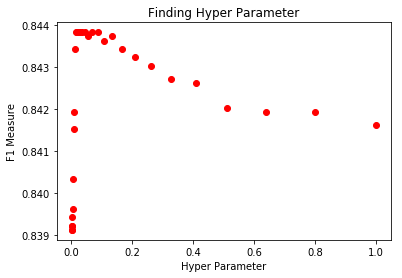

The best smoothing parameter alpha = 0.08589934592000005 
 F1 measure  = 0.8438312337532493


In [31]:
findAlpha_BNB(trainX, trainY, validX, validY)

Apply the best alpha and predit the test dataset with alpha = 0.08589934592000005 

In [37]:
BBOW_F1_BNB_train = BernoulliNativeBayes(trainX, trainY, trainX, trainY, 0.08589934592000005)
print("(BBOW) Training F1 Measure of Bernoulli NB with best hyper-parameter = {}".format(BBOW_F1_BNB_train))
BBOW_F1_BNB_valid = BernoulliNativeBayes(trainX, trainY, validX, validY, 0.08589934592000005)
print("(BBOW) Validation F1 Measure of Bernoulli NB with best hyper-parameter = {}".format(BBOW_F1_BNB_valid))
BBOW_F1_BNB_test = BernoulliNativeBayes(trainX, trainY, testX, testY, 0.08589934592000005)
print("(BBOW) Testing F1 Measure of Bernoulli NB with best hyper-parameter = {}".format(BBOW_F1_BNB_test))

(BBOW) Training F1 Measure of Bernoulli NB with best hyper-parameter = 0.8686929280810505
(BBOW) Validation F1 Measure of Bernoulli NB with best hyper-parameter = 0.8438312337532493
(BBOW) Testing F1 Measure of Bernoulli NB with best hyper-parameter = 0.8284925588094095


### Decision Tree

In [46]:
findHyperP_DT(trainX, trainY, validX, validY)

The best F1 measure  = 0.6959608078384323 
max_depth = 6 
min_sample_split = 0.040353606999999986


Apply the best max_depth and min_sample_split on the test set with max_depth = 6 and min_sample_split = 0.04035360699999998

In [47]:
BBOW_F1_DT_train = decisionTree(trainX, trainY, trainX, trainY, 0.04035360699999998, 6)
print("(BBOW) Training F1 Measure of Decision Tree with best hyper-parameter = {}".format(BBOW_F1_DT_train))
BBOW_F1_DT_valid = decisionTree(trainX, trainY, validX, validY, 0.04035360699999998, 6)
print("(BBOW) Validation F1 Measure of Decision Tree with best hyper-parameter = {}".format(BBOW_F1_DT_valid))
BBOW_F1_DT_test = decisionTree(trainX, trainY, testX, testY, 0.04035360699999998, 6)
print("(BBOW) Testing F1 Measure of Decision Tree with best hyper-parameter = {}".format(BBOW_F1_DT_test))

(BBOW) Training F1 Measure of Decision Tree with best hyper-parameter = 0.7064587082583483
(BBOW) Validation F1 Measure of Decision Tree with best hyper-parameter = 0.6959608078384323
(BBOW) Testing F1 Measure of Decision Tree with best hyper-parameter = 0.7058329332693231


### Linear SVM

Find best hyper parameter C and dual

In [48]:
c = 0.7
best_f1 = 0
bestC = 1.0
best_dual = False
for i in range(15):
    dual = False
    f1 = linearSVM(trainX, trainY, validX, validY,c, dual)
    if (f1 > best_f1):
        best_f1 = f1
        bestC = c
        best_dual = dual
    dual = True
    f1 = linearSVM(trainX, trainY, validX, validY, c, dual)
    if (f1 > best_f1):
        best_f1 = f1
        bestC = c
        best_dual = dual
    c *= 0.7

print("The F1 measure = {} \nC = {}\nDual = {}".format(best_f1, bestC, best_dual))

The F1 measure = 0.8787242551489702 
C = 0.004747561509942996
Dual = False


Apply the best hyper parameters with C = 0.004747561509942996 and dual = False

In [50]:
BBOW_F1_SVM_train = linearSVM(trainX, trainY, trainX, trainY, 0.004747561509942996, False)
print("(BBOW) Training F1 Measure of Linear SVM with best hyper-parameter = {}".format(BBOW_F1_SVM_train))
BBOW_F1_SVM_valid = linearSVM(trainX, trainY, validX, validY, 0.004747561509942996, False)
print("(BBOW) Validation F1 Measure of Linear SVM with best hyper-parameter = {}".format(BBOW_F1_SVM_valid))
BBOW_F1_SVM_test = linearSVM(trainX, trainY, testX, testY, 0.004747561509942996, False)
print("(BBOW) Testing F1 Measure of Linear SVM with best hyper-parameter = {}".format(BBOW_F1_SVM_test))

(BBOW) Training F1 Measure of Linear SVM with best hyper-parameter = 0.9470772512164234
(BBOW) Validation F1 Measure of Linear SVM with best hyper-parameter = 0.8787242551489702
(BBOW) Testing F1 Measure of Linear SVM with best hyper-parameter = 0.874739958393343


### Question 5

Now we use frequency bag of word for IMDB dataset

In [51]:
trainReviews = getReviews("output_datasets/IMDB-train.txt")
trainX = buildFreqBOW(trainReviews[0])
trainY = trainReviews[1]

validReviews = getReviews("output_datasets/IMDB-valid.txt")
validX = buildFreqBOW(validReviews[0])
validY = validReviews[1]

testReviews = getReviews("output_datasets/IMDB-test.txt")
testX = buildFreqBOW(testReviews[0])
testY = testReviews[1]

### Gaussian Native Bayes

In [52]:
FBOW_F1_GNB_train = GaussianNativeBayes(trainX, trainY, trainX, trainY)
print("(FBOW) Training F1 Measure of Gaussian NB = {}".format(FBOW_F1_GNB_train))
FBOW_F1_GNB_valid = GaussianNativeBayes(trainX, trainY, validX, validY)
print("(FBOW) Validation F1 Measure of Gaussian NB = {}".format(FBOW_F1_GNB_valid))
FBOW_F1_GNB_test = GaussianNativeBayes(trainX, trainY, testX, testY)
print("(FBOW) Testing F1 Measure of Gaussian NB = {}".format(FBOW_F1_GNB_test))

(FBOW) Training F1 Measure of Gaussian NB = 0.8565620209291475
(FBOW) Validation F1 Measure of Gaussian NB = 0.7521495700859829
(FBOW) Testing F1 Measure of Gaussian NB = 0.681148983837414


### Decision Tree

In [53]:
findHyperP_DT(trainX, trainY, validX, validY)

The best F1 measure  = 0.6993601279744052 
max_depth = 6 
min_sample_split = 0.49


Apply the best min_sample_split on the test set with min_sample_split = 0.49 and max_depth = 6

In [54]:
FBOW_F1_DT_train = decisionTree(trainX, trainY, trainX, trainY, 0.49, 6)
print("(FBOW) Training F1 Measure of Decision Tree with best hyper-parameter = {}".format(FBOW_F1_DT_train))
FBOW_F1_DT_valid = decisionTree(trainX, trainY, validX, validY, 0.49, 6)
print("(FBOW) Validation F1 Measure of Decision Tree with best hyper-parameter = {}".format(FBOW_F1_DT_valid))
FBOW_F1_DT_test = decisionTree(trainX, trainY, testX, testY, 0.49, 6)
print("(FBOW) Testing F1 Measure of Decision Tree with best hyper-parameter = {}".format(FBOW_F1_DT_test))

(FBOW) Training F1 Measure of Decision Tree with best hyper-parameter = 0.706125441578351
(FBOW) Validation F1 Measure of Decision Tree with best hyper-parameter = 0.6993601279744052
(FBOW) Testing F1 Measure of Decision Tree with best hyper-parameter = 0.7032325172027525


### Linear SVM

Find best hyper parameter C and dual

In [55]:
c = 1.0
best_f1 = 0
bestC = 1.0
best_dual = False
for i in range(20):
    dual = False
    f1 = linearSVM(trainX, trainY, validX, validY,c, dual)
    if (f1 > best_f1):
        best_f1 = f1
        bestC = c
        best_dual = dual
    dual = True
    f1 = linearSVM(trainX, trainY, validX, validY, c, dual)
    if (f1 > best_f1):
        best_f1 = f1
        bestC = c
        best_dual = dual
    c *= 1.2

print("The F1 measure = {} \nC = {}\nDual = {}".format(best_f1, bestC, best_dual))

The F1 measure = 0.876124775044991 
C = 31.947999937062274
Dual = False


Apply the best hyper parameters with C = 31.947999937062274 and dual = False

In [57]:
FBOW_F1_SVM_train = linearSVM(trainX, trainY, trainX, trainY, 31.947999937062274, False)
print("(FBOW) Training F1 Measure of Linear SVM with best hyper-parameter = {}".format(FBOW_F1_SVM_train))
FBOW_F1_SVM_valid = linearSVM(trainX, trainY, validX, validY, 31.947999937062274, False)
print("(FBOW) Validation F1 Measure of Linear SVM with best hyper-parameter = {}".format(FBOW_F1_SVM_valid))
FBOW_F1_SVM_test = linearSVM(trainX, trainY, testX, testY, 31.947999937062274, False)
print("(FBOW) Testing F1 Measure of Linear SVM with best hyper-parameter = {}".format(FBOW_F1_SVM_test))

(FBOW) Training F1 Measure of Linear SVM with best hyper-parameter = 0.9186829300806505
(FBOW) Validation F1 Measure of Linear SVM with best hyper-parameter = 0.876124775044991
(FBOW) Testing F1 Measure of Linear SVM with best hyper-parameter = 0.8739398303728596
